## Load modules

In [292]:
# -*- coding: utf-8 -*-
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import optimize
import scipy.optimize
#from scipy.ndimage import gaussian_filter1d
import sys

## Parameters

In [293]:
date = '20211129'
dataNo = 1
scanNo = 1

## Data Preparation

In [294]:
path = r"./"+date
path_img = path + r"/data" + str('%03d' % dataNo) + "/raw"
path_scan = path + r"/scandir/Scan" + str('%03d' % scanNo) + '.txt'
path_param = path + r"/scandir/Parameters" + str('%03d' % scanNo) + '.txt'
scan_data = pd.read_csv(path_scan, delimiter='\t')

In [295]:
scan_param = scan_data['A0047: Lattice amp. modulation freq.']
flcount = scan_data['Total count1 @ ROI1 (arb. u.)']

In [296]:
share = Path(path_img)
if share.exists():
    trans_files = list(Path(path_img).glob('seq*_trans001.tiff'))
    flat_files = list(Path(path_img).glob('seq*_flat001.tiff'))
    update_files = list(Path(path_img).glob('seq*_update001.tiff'))
else:
    print("No Data")

img_flat_ave =[]
img_trans_ave = []
for N in range(len(trans_files)):
    img_flat_ave += [np.array(Image.open(flat_files[N]))]
    img_trans_ave += [np.array(Image.open(trans_files[N]))]
img_flat_ave = np.average(img_flat_ave,axis=0)
img_trans_ave =np.average(img_trans_ave,axis=0) -img_flat_ave

## Sample images


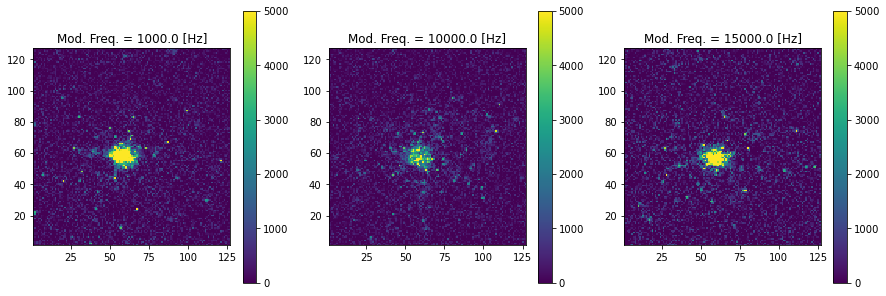

In [297]:
modfreq_sample1 = 1000 #[Hz]
modfreq_sample2 = 10000 #[Hz]
modfreq_sample3 = 15000 #[Hz]
# modfreq_sample4 = 15000 #[Hz]
img_trans_sample1 = []
img_trans_sample2 = []
img_trans_sample3 = []
for N in range(len(trans_files)):
    if scan_param[N] == modfreq_sample1:
        img_trans_sample1 += [np.array(Image.open(trans_files[N]))]
    elif scan_param[N] == modfreq_sample2:
        img_trans_sample2 += [np.array(Image.open(trans_files[N]))]
    elif scan_param[N] == modfreq_sample3:
        img_trans_sample3 += [np.array(Image.open(trans_files[N]))]
img_trans_sample1 = np.average(img_trans_sample1,axis=0) -img_flat_ave
img_trans_sample2 = np.average(img_trans_sample2,axis=0) -img_flat_ave
img_trans_sample3 = np.average(img_trans_sample3,axis=0) -img_flat_ave

fig =plt.figure(figsize=[15,5])
ax1 = fig.add_subplot(1,3,1)
mappable =ax1.pcolormesh(img_trans_sample1, vmin=0, vmax=5000, shading='auto')
ax1.set_aspect('equal')
ax1.set_xlim(1,127)
ax1.set_ylim(1,127)
ax1.set_title("Mod. Freq. = %.01f [Hz]"%(modfreq_sample1))
fig.colorbar(mappable)

ax2 = fig.add_subplot(1,3,2)
mappable =ax2.pcolormesh(img_trans_sample2, vmin=0, vmax=5000, shading='auto')
ax2.set_aspect('equal')
ax2.set_xlim(1,127)
ax2.set_ylim(1,127)
ax2.set_title("Mod. Freq. = %.01f [Hz]"%(modfreq_sample2))
fig.colorbar(mappable)

ax3 = fig.add_subplot(1,3,3)
mappable =ax3.pcolormesh(img_trans_sample3, vmin=0, vmax=5000, shading='auto')
ax3.set_aspect('equal')
ax3.set_xlim(1,127)
ax3.set_ylim(1,127)
ax3.set_title("Mod. Freq. = %.01f [Hz]"%(modfreq_sample3))
fig.colorbar(mappable)
plt.show()

Analysis area
--

In [298]:
cx = 59
cy = 59
wx = 6
wy = 6
x0 = cx-wx; x1 = cx+wx
y0 = cy-wy; y1 = cy+wy


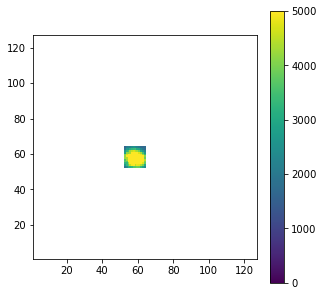

In [299]:
x=np.arange(x0,x1)
y=np.arange(y0,y1)
xmesh, ymesh = np.meshgrid(x,y)

fig =plt.figure(figsize=[5,5])
ax = fig.add_subplot(1,1,1)
mappable =ax.pcolormesh(xmesh,ymesh,img_trans_ave[y0:y1,x0:x1], vmin=0, vmax=5000, shading='auto')
ax.set_aspect('equal')
ax.set_xlim(1,127)
ax.set_ylim(1,127)
fig.colorbar(mappable)

### Averaging Data

In [300]:
img_trans_list =[]
for N in range(len(trans_files)):
    img_trans_temp = [np.array(Image.open(trans_files[N])) -img_flat_ave  ]
    img_trans_list +=[np.sum(img_trans_temp[0][y0:y1,x0:x1])/np.sum(img_trans_temp)]


unique_param = scan_param.unique()
od_list = []
od_err_list = []
for i in range(len(unique_param)):
    od_temp = []
    od_err_temp = []
    for j in range(len(trans_files)):
        if scan_param[j] == unique_param[i]:
            od_temp.append(img_trans_list[j])
    od_list.append(np.mean(od_temp))
    od_err_list.append(np.std(od_temp))

### Fitting to data

a1= -0.12316358809792458
b1= 9689.424412547512
c1= 2967.8270918913045
a2= -0.10258579351498785
b2= 6001.9309696515165
c2= 943.2933759554296


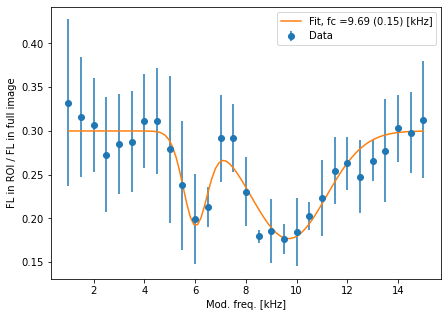

In [305]:
#Fitting to experimental data
# modfreq=modfreq[0:len(modfreq)-1]
# flcount=flcount[0:len(flcount)-1]

para_ini=[-0.05, 10000, 2000,-0.05, 6000, 1000,0.07]
def nonlinear_fit(x,a1,b1,c1,a2,b2,c2,d):
    return a1*np.exp(-2*(x-b1)**2/c1**2)+a2*np.exp(-2*(x-b2)**2/c2**2)+d

# param, cov=scipy.optimize.curve_fit(nonlinear_fit,modfreq,img_trans_list,para_ini)
param, cov=scipy.optimize.curve_fit(nonlinear_fit,unique_param,od_list,para_ini)
list_x1=np.linspace(np.min(unique_param),np.max(unique_param),100)
list_y1=[]
for num in list_x1:
    list_y1.append(param[0]*np.exp(-2*(num-param[1])**2/param[2]**2)+param[3]*np.exp(-2*(num-param[4])**2/param[5]**2)+param[6])

perr=np.sqrt(np.diag(cov))
print("a1=",str(param[0]))
print("b1=",str(param[1]))
print("c1=",str(param[2]))
print("a2=",str(param[3]))
print("b2=",str(param[4]))
print("c2=",str(param[5]))
# para_ini=[-0.01, 10000, 5000,0.07]
# # modfreq=modfreq[0:len(modfreq)-1]
# def nonlinear_fit(x,a1,b1,c1,d):
#     return a1*np.exp(-2*(x-b1)**2/c1**2)+d

# param, cov=scipy.optimize.curve_fit(nonlinear_fit,modfreq,img_trans_list,para_ini)

# list_x1=list(x for x in range(int(np.min(modfreq)),int(np.max(modfreq))))
# list_y1=[]
# for num in list_x1:
#     list_y1.append(param[0]*np.exp(-2*(num-param[1])**2/param[2]**2)+param[3])

# perr=np.sqrt(np.diag(cov))
# print("a1=",str(param[0]))
# print("b1=",str(param[1]))
# print("c1=",str(param[2]))
# plt.scatter(modfreq*1.0e-3,img_trans_list, label='Data',c="r")
# plt.plot(np.array(list_x1)*1.0e-3,list_y1, label='Fit, fc =%.02f (%.02f) [kHz]'%(param[1]*1.0e-3,perr[1]*1.0e-3))
# plt.legend()
# plt.xlim(0,15)
fig = plt.figure(figsize=[7,5])
ax = fig.add_subplot(1,1,1)
ax.errorbar(unique_param*1e-3,od_list,od_err_list,fmt='o',label="Data")
ax.plot(list_x1*1e-3,list_y1,label='Fit, fc =%.02f (%.02f) [kHz]'%(param[1]*1.0e-3,perr[1]*1.0e-3))
ax.set_xlabel("Mod. freq. [kHz]")
ax.set_ylabel("FL in ROI / FL in full image")
ax.legend()

## Summary

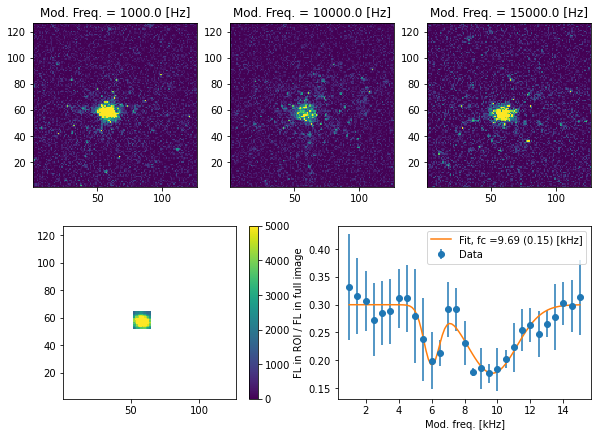

In [312]:
fig = plt.figure(figsize=[10,7])
ax1 = fig.add_subplot(2,3,1)
mappable =ax1.pcolormesh(img_trans_sample1, vmin=0, vmax=5000, shading='auto')
ax1.set_aspect('equal')
ax1.set_xlim(1,127)
ax1.set_ylim(1,127)
ax1.set_title("Mod. Freq. = %.01f [Hz]"%(modfreq_sample1))


ax2 = fig.add_subplot(2,3,2)
mappable =ax2.pcolormesh(img_trans_sample2, vmin=0, vmax=5000, shading='auto')
ax2.set_aspect('equal')
ax2.set_xlim(1,127)
ax2.set_ylim(1,127)
ax2.set_title("Mod. Freq. = %.01f [Hz]"%(modfreq_sample2))


ax3 = fig.add_subplot(2,3,3)
mappable =ax3.pcolormesh(img_trans_sample3, vmin=0, vmax=5000, shading='auto')
ax3.set_aspect('equal')
ax3.set_xlim(1,127)
ax3.set_ylim(1,127)
ax3.set_title("Mod. Freq. = %.01f [Hz]"%(modfreq_sample3))


ax4 = fig.add_subplot(2,2,3)
mappable =ax4.pcolormesh(xmesh,ymesh,img_trans_ave[y0:y1,x0:x1], vmin=0, vmax=5000, shading='auto')
ax4.set_aspect('equal')
ax4.set_xlim(1,127)
ax4.set_ylim(1,127)
fig.colorbar(mappable)

ax5 = fig.add_subplot(2,2,4)
ax5.errorbar(unique_param*1e-3,od_list,od_err_list,fmt='o',label="Data")
ax5.plot(list_x1*1e-3,list_y1,label='Fit, fc =%.02f (%.02f) [kHz]'%(param[1]*1.0e-3,perr[1]*1.0e-3))
ax5.set_xlabel("Mod. freq. [kHz]")
ax5.set_ylabel("FL in ROI / FL in full image")
ax5.legend()